# MultiSensor Monitoring for WL-DED
- Experiment data: March 2024. Aluminum, Laser-Wire DED
- Aurthor: Chen Lequn

### Notebook 7a: Training Audio CNN for classification
- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on thermal image dataset.
- Best performance will guide subsequent multimodal fusion network development.

## 1. Import Libraries

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import numpy as np
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys
import shutil
import itertools
from tqdm.notebook import tqdm

from torch.cuda.amp import GradScaler, autocast
# Mixed Precision Training
scaler = GradScaler()

In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [13]:
import sys
sys.path.append('utils')
from plotting import *
from utils_functions import loss_acc_plot

os.environ['TORCH_HOME'] = '/home/chenlequn/pan1/torch_models'

# Define batch size
batch_size = 32
EPOCHS = 10

### Use GPU if possible

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
# mp.set_start_method(method='forkserver', force=True)

Using cuda


In [5]:
torch.manual_seed(0)

### 2. Define Dataset Path

In [10]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'vision-cnn')
model_path = os.path.join("/home/chenlequn/pan1/trained_models", 'defect classification', 'vision-cnn')
scaler_path = os.path.join(PROJECT_ROOT_DIR, "saved_scalers", 'defect classification',  'vision-cnn')
os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(scaler_path, exist_ok=True)


# Change to desirable location of the raw dataset
Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset"
Annotation_file_path = os.path.join(Multimodal_dataset_PATH, "Annotation")
Dataset_path = os.path.join(Multimodal_dataset_PATH, 'Dataset')
final_audio_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "audio")
final_image_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "thermal_images")
YOLO_test_path = os.path.join(Multimodal_dataset_PATH, 'YOLO-test')
os.makedirs(YOLO_test_path, exist_ok=True)
              
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [7]:
# Read the data back from the HDF5 file into a new DataFrame
df_dataset = pd.read_hdf(os.path.join(Dataset_path, 'df_audio_dataset_with_annotations(raw_audio).h5'), key='df')
df_dataset

audio_name                 image_name experiment_number  \
0               Exp_17_12_1.wav            Exp_17_12_1.jpg             17_12   
1               Exp_17_12_2.wav            Exp_17_12_2.jpg             17_12   
2               Exp_17_12_3.wav            Exp_17_12_3.jpg             17_12   
3               Exp_17_12_4.wav            Exp_17_12_4.jpg             17_12   
4               Exp_17_13_6.wav            Exp_17_13_6.jpg             17_13   
...                         ...                        ...               ...   
3503  Exp_April_16_test_4_4.wav  Exp_April_16_test_4_4.jpg   April_16_test_4   
3504  Exp_April_16_test_4_1.wav  Exp_April_16_test_4_1.jpg   April_16_test_4   
3505  Exp_April_16_test_4_2.wav  Exp_April_16_test_4_2.jpg   April_16_test_4   
3506  Exp_April_16_test_4_3.wav  Exp_April_16_test_4_3.jpg   April_16_test_4   
3507  Exp_April_16_test_4_5.wav  Exp_April_16_test_4_5.jpg   April_16_test_4   

            label_1            label_2 label_3  rms_energy  \
0     Balling (LoF)                NaN     NaN    0.055400   
1     Balling (LoF)                NaN     NaN    0.037319   
2     Balling (LoF)                NaN     NaN    0.028314   
3     Balling (LoF)                NaN     NaN    0.025656   
4     Balling (LoF)                NaN     NaN    0.019992   
...             ...                ...     ...         ...   
3503      Laser-off  Shielding Gas-off     NaN    0.012902   
3504      Laser-off  Shielding Gas-off     NaN    0.013222   
3505      Laser-off  Shielding Gas-off     NaN    0.012246   
3506      Laser-off  Shielding Gas-off     NaN    0.013367   
3507      Laser-off  Shielding Gas-off     NaN    0.012981   

      amplitude_envelope_mean  amplitude_envelope_std  zero_crossing_rate  \
0                    0.063368                0.014181            0.021542   
1                    0.047844                0.013682            0.057370   
2                    0.030773                0.013055            0.083900   
3                    0.033076                0.009994            0.080726   
4                    0.029970                0.007434            0.051927   
...                       ...                     ...                 ...   
3503                 0.015071                0.005879            0.099093   
3504                 0.015257                0.005407            0.084127   
3505                 0.014805                0.005100            0.093878   
3506                 0.016546                0.005384            0.087302   
3507                 0.015662                0.005640            0.076417   

      ...  mfcc_8_mean  mfcc_8_std  mfcc_9_mean  mfcc_9_std  mfcc_10_mean  \
0     ...     4.465534    5.621855    10.530560    7.604537      1.019614   
1     ...     3.375155    6.320611     5.001470    8.519529     -3.618283   
2     ...     0.212402    6.042810     3.667673    6.774061     -4.279868   
3     ...    -2.960245   10.497297     3.910449    7.278681      0.686291   
4     ...    -2.866064    6.072939     5.428969   10.252683     -3.750278   
...   ...          ...         ...          ...         ...           ...   
3503  ...     2.168951    6.490287     1.928032    8.401035     -1.724736   
3504  ...     0.476796    9.227147     0.945553    7.366714     -1.322515   
3505  ...    -0.026498    7.503857     2.117017    7.400688     -2.097013   
3506  ...     1.089101    6.276635     0.685349    5.679959     -5.039695   
3507  ...     1.269098    6.512943     2.457465    8.290963     -2.943163   

      mfcc_10_std  mfcc_11_mean  mfcc_11_std  mfcc_12_mean  mfcc_12_std  
0        5.977480     11.476974     6.662732     -8.070549     8.544114  
1       10.137958      8.518948     8.286986    -12.481044     8.784910  
2        5.320736      5.285318     6.426253    -13.551059     6.355420  
3        9.202967      9.157614     7.613472    -13.765296     6.685709  
4        7.586510      3.211762     5.490491     -5.946276     7.376266  
...           ...    

Saving figure dataset_distribution


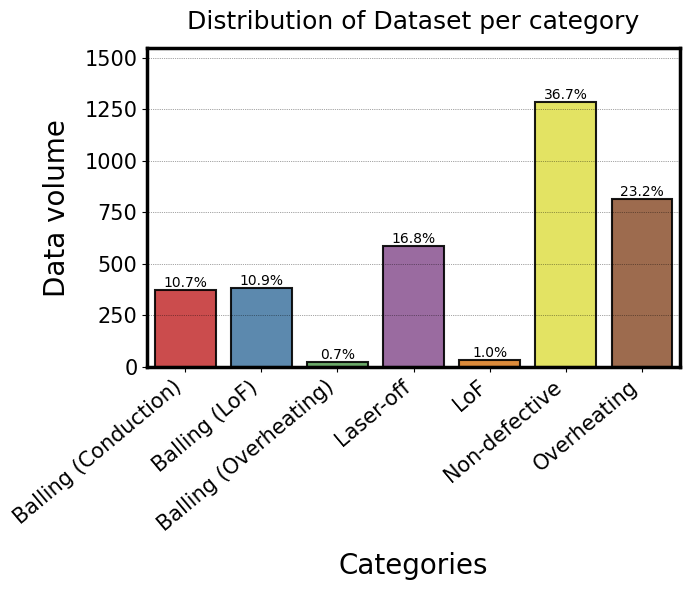

In [8]:
plot_data_distribution(df_dataset, 'label_1', 
                       'Distribution of Dataset per category', 'dataset_distribution', IMAGE_PATH)

In [9]:
# Define the classes
classes = ['Balling (Conduction)', 'Balling (LoF)', 'Balling (Overheating)', 'Laser-off', 'LoF', 'Non-defective', 'Overheating']

In [11]:
# Create the "YOLO-test" directory and subdirectories for each class
os.makedirs(YOLO_test_path, exist_ok=True)
for class_name in classes:
    class_dir = os.path.join(YOLO_test_path, class_name)
    os.makedirs(class_dir, exist_ok=True)

In [14]:
# Function to create toy dataset
def create_toy_dataset(df, image_path, output_path, classes, num_samples=100):
    for class_name in classes:
        # Filter the DataFrame for the current class
        df_class = df[df['label_1'] == class_name]
        # Get the image names
        image_names = df_class['image_name'].values
        # Randomly select up to num_samples images
        selected_images = np.random.choice(image_names, size=min(num_samples, len(image_names)), replace=False)
        # Copy the selected images to the class directory
        for image_name in selected_images:
            src = os.path.join(image_path, image_name)
            dst = os.path.join(output_path, class_name, image_name)
            shutil.copy(src, dst)

In [15]:
# Create the toy dataset
create_toy_dataset(df_dataset, final_image_dataset, YOLO_test_path, classes, num_samples=100)

In [16]:
# Print completion message
print(f"Toy dataset created in {YOLO_test_path}")

Toy dataset created in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/YOLO-test


Saving figure toy_dataset_distribution


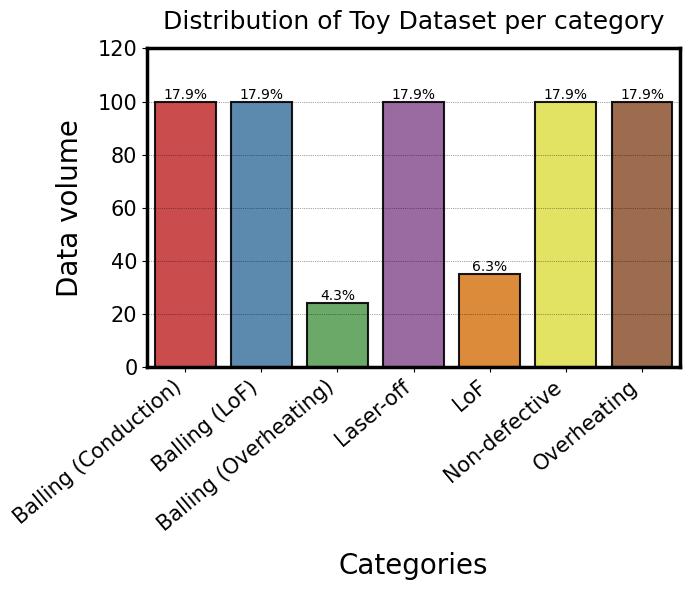

In [17]:
# Plot the class distribution of the toy dataset (optional)
toy_df = pd.DataFrame(columns=df_dataset.columns)
for class_name in classes:
    class_dir = os.path.join(YOLO_test_path, class_name)
    images = os.listdir(class_dir)
    toy_df = toy_df.append(pd.DataFrame({'image_name': images, 'label_1': class_name}), ignore_index=True)

plot_data_distribution(toy_df, 'label_1', 
                       'Distribution of Toy Dataset per category', 'toy_dataset_distribution', YOLO_test_path)